## This code is to compare the inverted mask basis of DCT and Haar

In [1]:
using FFTW, LinearAlgebra, Distributions, Random, Images, TestImages, ImageMagick, PyPlot;

function idctmtx(dims)
    ## produce a DCT matrix like matlab
    diag = I(dims);
    D = zeros(dims,dims);
    for i = 1:dims
        D[:,i] = idct(diag[:,i]);
    end
    return D;
end

## 2.
function IDCT_basis(r_tot,c_tot)
    ## produce a hyper resolution DMD measurement basis series
    ##verified by Python; 
    # making a idct2 matrix in a vector form
    D1 = idctmtx(r_tot);
    D2 = idctmtx(c_tot);
    N = r_tot * c_tot;
    Basis = zeros(N,N);
    
    i = 1;
    for ir = 1:r_tot
        for ic = 1:c_tot
            
            Basis_Vector = D1[ir:ir,:]' * D2[ic:ic,:];
            Basis[i,:] = reshape(Basis_Vector', (1,:));
            i += 1;
        end
        
    end
    return Basis;
end

function dctmtx(dims)
    ## produce a DCT matrix like matlab
    diag = I(dims);
    D = zeros(dims,dims);
    for i = 1:dims
        D[:,i] = dct(diag[:,i]);
    end
    return D;
end

## 2.
function DCT_basis(r_tot,c_tot)
    ## produce a hyper resolution DMD measurement basis series
    ##verified by Python; 
    # making a idct2 matrix in a vector form
    D1 = dctmtx(r_tot);
    D2 = dctmtx(c_tot);
    N = r_tot * c_tot;
    Basis = zeros(N,N);
    
    i = 1;
    for ir = 1:r_tot
        for ic = 1:c_tot
            
            Basis_Vector = D1[ir:ir,:]' * D2[ic:ic,:];
            Basis[i,:] = reshape(Basis_Vector', (1,:));
            i += 1;
        end
        
    end
    return Basis;
end

## 3.
function Poisson_noise(signal)
    return rand.(Poisson.(signal));
end

## 4 Haar matrix
##============================
function Resize(mat, new_size)
    r,c = new_size;
    r0, c0 = size(mat);
    mat2 = zeros(r,c)
    for i = 1:r
        y = Int(ceil(i * r0 / r));
        for j = 1:c
            x = Int(ceil(j * c0 / c));
            mat2[i,j] = mat[y,x];
        end
    end
    return mat2;    
end

function Haar_tree(seed_raw)    
    r,c = size(seed_raw);
    r2 = Int(round(r/2));
    c2 = Int(round(c/2));
    seed = Resize(seed_raw, (r2,c2));
    k1 = [1 0; 0 0];
    k2 = [0 1; 0 0];
    k3 = [0 0; 1 0];
    k4 = [0 0; 0 1];
    
    out = zeros(2*r, 2*c);
    
    out[1:r,1:c] = kron(k1, seed);
    out[1:r,c+1:2*c] = kron(k2, seed);
    out[r+1:2*r,1:c] = kron(k3, seed);
    out[r+1:2*r, c+1:2*c] = kron(k4, seed);
    
    return out;
end

function make_tensor(n, seed, row,col)
    # r is the edge
    r = 2^(n);    

    tensor = zeros(row,col,2^(2*n));
    layer = 1;
    
    sub = zeros(r,r);
    for i = 1:2^n
        for j = 1:2^n
            
            #sub = matrix[(i-1)*r+1: i*r, (j-1)*r+1:j*r];
            sub[i,j] = 1;
            
            tensor[:,:,layer] = Resize(kron(sub,seed), (row,col));
            sub[i,j] = 0;
            layer+=1;
        end
    end
    return tensor;
end

function Haar_recursion(row,col)
    ## currently please let row = col = 2^n
    haar_tensor = zeros(row,col,(row*col));
    
    seed1= [1 1; 1 1];
    seed2= [1 -1; 1 -1];
    seed3 = [1 1; -1 -1];
    seed4 = [1 -1; -1 1];
    
    kernel1 = Resize([1 1; 1 1], (row,col));
    kernel2 = Resize([1 -1; 1 -1], (row,col));
    kernel3 = Resize([1 1; -1 -1],(row,col));
    kernel4 = Resize([1 -1; -1 1],(row,col));
    haar_tensor[:,:,1] = kernel1;
    haar_tensor[:,:,2] = kernel2;
    haar_tensor[:,:,3] = kernel3;
    haar_tensor[:,:,4] = kernel4;
    
    layer = 4;
    kernel_edge = row;
    N = 1;
    while kernel_edge >= 4
        
        #kernel2 = Haar_tree(kernel2);
        
        t1 = make_tensor( N, seed2, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        #kernel3 = Haar_tree(kernel3);
        t1 = make_tensor( N, seed3, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        #kernel4 = Haar_tree(kernel4);
        t1 = make_tensor( N, seed4, row,col);
        L = length(t1[1,1,:]);
        haar_tensor[:,:, layer+1:layer+L] = t1;
        layer += L;
        
        kernel_edge /= 2;     
        N += 1;
    end
    
    haar_2d = zeros(row*col,row*col);
    for i = 1:row*col
        vec = reshape(haar_tensor[:,:,i]', (1,:));
        abs_sum = sum(abs.(vec));
        haar_2d[i,:] = vec ./ abs_sum^0.5;
    end
    
    haar_tensor = nothing;
    
    return haar_2d;
end
##============================

Haar_recursion (generic function with 1 method)

In [2]:
## 7 load image as matrix
function Img2matrix(pathname, r = false, c = false, RGB = true)
    img = channelview(load(pathname));
    r0, c0 = size(img[1,:,:]);
    
    if r == false
        r = r0;
    end
    if c == false
        c = c0;
    end
    
    red = imresize(img[1,:,:], (r,c));
    green = imresize(img[2,:,:], (r,c));
    blue = imresize(img[3,:,:], (r,c));
    
    if RGB == true
        matrix = zeros(r,c,3);
        matrix[:,:,1] = red;
        matrix[:,:,2] = green;
        matrix[:,:,3] = blue;
        
    else
        matrix = zeros(r,c);
        matrix = 0.21 * red  + 0.72 * green + 0.07 * blue;
    end
    
    return matrix;
end
##===============================================

Img2matrix (generic function with 4 methods)

In [3]:
function PMT_measure_simu(photon_number, cycles, upload_image, upload_basis, Poisson = true)
    ### photon - number is the photons of each pixel during each measurement
    ### cycles : the compression rate; 
    ### Poisson : true, adding poisson noise
    ### upload_image : Black white image (matrix)
    image = upload_image / maximum(upload_image);
    r_tot, c_tot = size(upload_image);
    #=
    if upload_basis == "null"
        DMD_basis = DMD_measure_basis(r_tot, c_tot, cycles);
    else
        DMD_basis = upload_basis[1:cycles,:];
    end
    =#
    DMD_basis = upload_basis[1:cycles,:];
    
    image_vector = reshape(image', (:, 1));
    image_vector *= photon_number; ## here you are light up a image
    
    measurements = zeros(cycles,1); 
    ### if you want to do RGB image later, set zeros(cycles,3)
    
    for i = 1:cycles
        #val = DMD_basis[i:i,:] * image_vector;
        
        if Poisson == true
            #val = Poisson_noise(val);
            val = DMD_basis[i:i,:] * Poisson_noise(image_vector);
        else
            val = DMD_basis[i:i,:] * image_vector;
        end
        measurements[i,:] = val;
        #YZ_process_bar(i/cycles);
    end
    
    measurements /= photon_number;
    
    return measurements;
end

PMT_measure_simu (generic function with 2 methods)

In [4]:
r = 64;
c = 64;
img = Img2matrix("ECE.jpg",r,c,false);
N = 15;
time_series = [i for i = 1:N]./N .*500;
photon_per_second = 1e6;

phi_dct = IDCT_basis(r, c);
phi_haar = Haar_recursion(r, c);
phi_ceil_dct = ceil.(phi_dct); ## the 0-1 mask
phi_sign_dct = sign.(phi_dct); ## the 0-1 mask


#inv_phi_idct = DCT_basis(r, c);
inv_phi_dct = phi_dct';
inv_phi_haar = phi_haar';
inv_phi_ceil_dct = inv(phi_ceil_dct);
inv_phi_sign_dct = inv(phi_sign_dct);

BS_dct_error = zeros(length(time_series),1);
BS_haar_error = zeros(length(time_series),1);
BS_ceil_dct_error = zeros(length(time_series),1);
BS_sign_dct_error = zeros(length(time_series),1);

In [5]:
for time_slot = 1 : length(time_series)
    
    time = time_series[time_slot];
    total_photons = photon_per_second * time;
    photon_per_mask_per_pixel = total_photons / (r*c)/(r*c);
    
    dct_measurement = PMT_measure_simu(photon_per_mask_per_pixel, r*c, img, phi_dct, true);
    dct_recons_vector = inv_phi_dct * dct_measurement;
    dct_recons_img = reshape(dct_recons_vector, (r,c))';
    BS_dct_error[time_slot] = mean((dct_recons_img .- img).^2);
    
    haar_measurement = PMT_measure_simu(photon_per_mask_per_pixel, r*c, img, phi_haar, true);
    haar_recons_vector = inv_phi_haar * haar_measurement;
    haar_recons_img = reshape(haar_recons_vector, (r,c))';
    BS_haar_error[time_slot] = mean((haar_recons_img .- img).^2);
    
    ceil_dct_measurement = PMT_measure_simu(photon_per_mask_per_pixel, r*c, img, phi_ceil_dct, true);
    ceil_dct_recons_vector = inv_phi_ceil_dct * ceil_dct_measurement;
    ceil_dct_recons_img = reshape(ceil_dct_recons_vector, (r,c))';
    BS_ceil_dct_error[time_slot] = mean((ceil_dct_recons_img .- img).^2);
    
    sign_dct_measurement = PMT_measure_simu(photon_per_mask_per_pixel, r*c, img, phi_sign_dct, true);
    sign_dct_recons_vector = inv_phi_sign_dct * sign_dct_measurement;
    sign_dct_recons_img = reshape(sign_dct_recons_vector, (r,c))';
    BS_sign_dct_error[time_slot] = mean((sign_dct_recons_img .- img).^2);
    
end

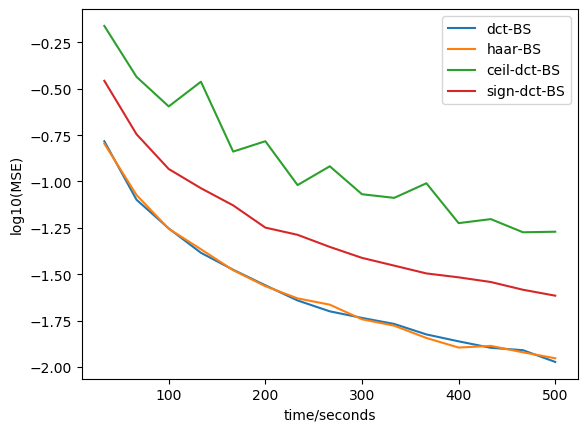

In [6]:
figure();
plot(time_series, log10.(BS_dct_error), label = "dct-BS");
plot(time_series, log10.(BS_haar_error), label = "haar-BS");
plot(time_series, log10.(BS_ceil_dct_error), label = "ceil-dct-BS");
plot(time_series, log10.(BS_sign_dct_error), label = "sign-dct-BS");

legend();
xlabel("time/seconds");
ylabel("log10(MSE)");

In [7]:
a = [1 2.5 ; 3 4];
ceil.(a)

2×2 Array{Float64,2}:
 1.0  3.0
 3.0  4.0

In [8]:
reshape(reshape(a, (:,1))',(2,2))'

2×2 Adjoint{Float64,Base.ReshapedArray{Float64,2,Adjoint{Float64,Array{Float64,2}},Tuple{Base.MultiplicativeInverses.SignedMultiplicativeInverse{Int64}}}}:
 1.0  3.0
 2.5  4.0

In [9]:
b = [1 2; -3 -4];
sign.(b)

2×2 Array{Int64,2}:
  1   1
 -1  -1

In [17]:
mean(phi_ceil_dct)

0.5001220703125

In [18]:
mean(phi_sign_dct)

0.000244140625

In [19]:
mean(phi_dct)

3.8146972656249996e-6

In [5]:
a = [i for i = 1:5]

5-element Array{Int64,1}:
 1
 2
 3
 4
 5

In [9]:
a - sum(a)/length(a)

MethodError: MethodError: no method matching -(::Array{Int64,1}, ::Float64)
Closest candidates are:
  -(!Matched::Float64, ::Float64) at float.jl:403
  -(!Matched::Complex{Bool}, ::Real) at complex.jl:303
  -(!Matched::Missing, ::Number) at missing.jl:115
  ...